In [2]:
# ============================================
# Bayesian Lung Segmentation on Kaggle Dataset "beosup/lung-segment"
# Using Aleatoric + Epistemic Uncertainty and AvU Loss
# ============================================

!pip install kagglehub --quiet

import os
import cv2
import glob
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import Dataset, DataLoader

import kagglehub

# Step 1: Download Dataset from KaggleHub
path = kagglehub.dataset_download("beosup/lung-segment")
image_dir = os.path.join(path, "images")
mask_dir = os.path.join(path, "masks")

100%|██████████| 4.10G/4.10G [03:18<00:00, 22.1MB/s]

Extracting files...


In [3]:
# Verify if the paths are correct and if the images and masks are present
print(f"Image directory: {image_dir}")
print(f"Mask directory: {mask_dir}")
print(f"Number of images: {len(os.listdir(image_dir))}")
print(f"Number of masks: {len(os.listdir(mask_dir))}")

Image directory: /root/.cache/kagglehub/datasets/beosup/lung-segment/versions/1/images
Mask directory: /root/.cache/kagglehub/datasets/beosup/lung-segment/versions/1/masks
Number of images: 800
Number of masks: 704


In [4]:
# DEBUGGING: Show first few image/mask filenames
print("Sample image files:", os.listdir(image_dir)[:5])
print("Sample mask files:", os.listdir(mask_dir)[:5])

# Check common base names
image_files = sorted(glob.glob(os.path.join(image_dir, '*.jpg')))
mask_files = sorted(glob.glob(os.path.join(mask_dir, '*.png')))
image_basenames = {os.path.splitext(os.path.basename(p))[0] for p in image_files}
mask_basenames = {os.path.splitext(os.path.basename(p))[0] for p in mask_files}
common_keys = sorted(image_basenames & mask_basenames)

print(f"Image count: {len(image_files)}")
print(f"Mask count: {len(mask_files)}")
print(f"Common base names found: {len(common_keys)}")
print("Some common keys:", common_keys[:5])


Sample image files: ['167.png', '235.png', '11.png', '682.png', '263.png']
Sample mask files: ['763-mask.png', '483-mask.png', '558-mask.png', '721-mask.png', '481-mask.png']
Image count: 0
Mask count: 704
Common base names found: 0
Some common keys: []


In [11]:
# Step 2: Define Dataset Class with base filename matching, allowing .png for both
class LungSegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir):
        image_files = sorted(glob.glob(os.path.join(image_dir, '*.png')))
        mask_files = sorted(glob.glob(os.path.join(mask_dir, '*-mask.png')))

        image_map = {os.path.splitext(os.path.basename(p))[0]: p for p in image_files}
        # Remove '-mask' from mask keys
        mask_map = {os.path.splitext(os.path.basename(p))[0].replace('-mask', ''): p for p in mask_files}

        common_keys = sorted(set(image_map.keys()) & set(mask_map.keys()))

        self.image_paths = [image_map[k] for k in common_keys]
        self.mask_paths = [mask_map[k] for k in common_keys]

        print(f"Loaded {len(self.image_paths)} matched image-mask pairs.")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert("L").resize((256, 256))
        mask = Image.open(self.mask_paths[idx]).convert("L").resize((256, 256))

        img = np.array(img) / 255.0
        mask = (np.array(mask) > 127).astype(np.float32)

        return {
            'image': torch.tensor(img[None, :, :], dtype=torch.float32),
            'mask': torch.tensor(mask[None, :, :], dtype=torch.float32)
        }

In [12]:
# Step 3: Define Bayesian U-Net with Dropout
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.ReLU(),
            nn.Dropout2d(0.3),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.ReLU()
        )

    def forward(self, x):
        return self.block(x)

class BayesianUNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc1 = ConvBlock(1, 32)
        self.pool = nn.MaxPool2d(2)
        self.enc2 = ConvBlock(32, 64)
        self.up = nn.ConvTranspose2d(64, 32, 2, 2)
        self.dec1 = ConvBlock(64, 32)
        self.final = nn.Conv2d(32, 1, 1)

    def forward(self, x):
        x1 = self.enc1(x)
        x2 = self.enc2(self.pool(x1))
        x = self.up(x2)
        x = torch.cat([x1, x], dim=1)
        x = self.dec1(x)
        return torch.sigmoid(self.final(x))


In [13]:
# Step 4: Aleatoric Uncertainty Simulation
def simulate_aleatoric_uncertainty(mask):
    mask = mask.cpu().squeeze().numpy().astype(np.uint8)
    kernel = np.ones((3, 3), np.uint8)
    op = np.random.choice(['erode', 'dilate'])
    transformed = cv2.erode(mask, kernel, 1) if op == 'erode' else cv2.dilate(mask, kernel, 1)
    return torch.tensor(transformed[None, :, :], dtype=torch.float32)

# Step 5: AvU Loss
def avu_loss(pred, uncertainty, target):
    with torch.no_grad():
        incorrect = ((pred > 0.5) != target.bool()).float()
    return torch.mean(torch.abs(uncertainty - incorrect))


In [25]:
# Step 6: evaluating Standard AvU model
def compute_avu(pred, uncertainty, target):
    incorrect = ((pred > 0.5) != target.bool()).float()
    avu = torch.mean(torch.abs(uncertainty - incorrect)).item()
    return avu

def evaluate_model(model, dataset, device, use_avu=False):
    model.eval()
    dice_scores = []
    avu_scores = []

    for i in range(20):
        sample = dataset[i]
        img = sample['image'].unsqueeze(0).to(device)
        target = sample['mask'].to(device)

        def enable_dropout(m):
            if isinstance(m, nn.Dropout2d): m.train()
        model.apply(enable_dropout)

        with torch.no_grad():
            preds = torch.stack([model(img) for _ in range(10)])
        mean_pred = preds.mean(0).squeeze()
        uncertainty = preds.std(0).squeeze()
        binarized = (mean_pred > 0.5).float()

        dice = f1_score(target.cpu().numpy().flatten(), binarized.cpu().numpy().flatten())
        dice_scores.append(dice)

        if use_avu:
            avu = compute_avu(mean_pred, uncertainty, target)
            avu_scores.append(avu)
        else:
            avu_scores.append(0.0)

    return np.mean(dice_scores), np.mean(avu_scores)


In [19]:
# Step 7: Training Loop
def train_model(model, dataloader, optimizer, device, epochs=5):
    model.train()
    for epoch in range(epochs):
        for batch in dataloader:
            img = batch['image'].to(device)
            mask = batch['mask'].to(device)
            perturbed = torch.stack([simulate_aleatoric_uncertainty(m) for m in mask]).to(device)

            optimizer.zero_grad()
            pred = model(img)
            samples = torch.stack([model(img) for _ in range(3)])
            uncertainty = torch.std(samples, dim=0)

            loss = nn.BCELoss()(pred, perturbed) + avu_loss(pred, uncertainty, perturbed)
            loss.backward()
            optimizer.step()
        print(f"Epoch {epoch+1}: Loss = {loss.item():.4f}")

In [20]:
# Step 7: Visualization and Evaluation
from sklearn.metrics import jaccard_score, f1_score # Importing jaccard_score and f1_score

def visualize(model, sample, device):
    model.eval()
    img = sample['image'].unsqueeze(0).to(device)
    true_mask = sample['mask'].squeeze().numpy()

    # Enable dropout at eval time for MC sampling
    def enable_dropout(m):
        if isinstance(m, nn.Dropout2d):
            m.train()
    model.apply(enable_dropout)

    with torch.no_grad():
        preds = torch.stack([model(img) for _ in range(5)])
    mean_pred = preds.mean(0).squeeze().cpu().numpy()
    std_pred = preds.std(0).squeeze().cpu().numpy()

    binarized = (mean_pred > 0.5).astype(np.uint8)
    iou = jaccard_score(true_mask.flatten(), binarized.flatten())
    dice = f1_score(true_mask.flatten(), binarized.flatten())

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 4, 1); plt.title("Image"); plt.imshow(img[0, 0].cpu(), cmap='gray')
    plt.subplot(1, 4, 2); plt.title("Ground Truth"); plt.imshow(true_mask, cmap='gray')
    plt.subplot(1, 4, 3); plt.title("Prediction"); plt.imshow(mean_pred, cmap='gray')
    plt.subplot(1, 4, 4); plt.title("Uncertainty"); plt.imshow(std_pred, cmap='hot')
    plt.suptitle(f"IoU: {iou:.3f} | Dice: {dice:.3f}")
    plt.show()

Loaded 704 matched image-mask pairs.
Epoch 1: Loss = 0.5356
Epoch 2: Loss = 0.5686
Epoch 3: Loss = 0.4766
Epoch 4: Loss = 0.3963
Epoch 5: Loss = 0.3890
Epoch 6: Loss = 0.3369
Epoch 7: Loss = 0.2162
Epoch 8: Loss = 0.4460
Epoch 9: Loss = 0.2435
Epoch 10: Loss = 0.2150


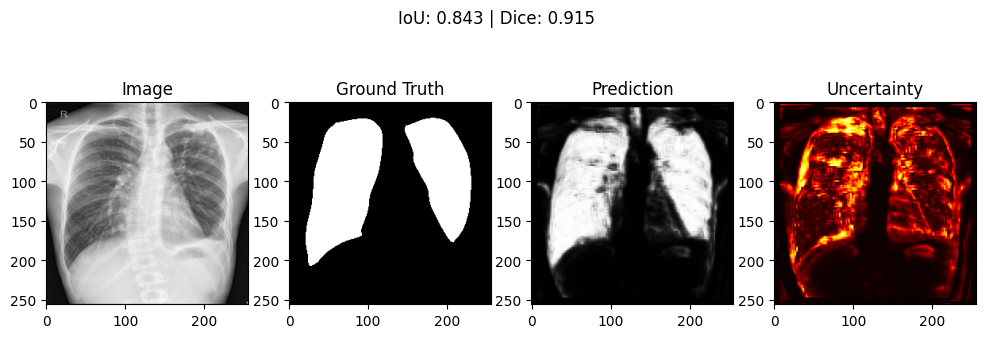

In [22]:
# Step 8: Run Everything
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset = LungSegmentationDataset(image_dir, mask_dir)
if len(dataset) == 0:
    raise ValueError("No matching image-mask pairs found. Please check the dataset integrity.")
dataloader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=2, pin_memory=True)

model = BayesianUNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

train_model(model, dataloader, optimizer, device, epochs=10)
visualize(model, dataset[0], device)

In [24]:
print("\n📊 Final Test Performance:")
print(f"{'Model':<20} {'Dice':<10} {'AvU'}")

# 1. Standard UNet
class StandardUNet(BayesianUNet):
    def __init__(self):
        super().__init__()
        for m in self.modules():
            if isinstance(m, nn.Dropout2d):
                m.p = 0.0  # Disable dropout

model_std = StandardUNet().to(device)
train_model(model_std, dataloader, torch.optim.Adam(model_std.parameters(), lr=1e-3), device, epochs=10)
dice, avu = evaluate_model(model_std, dataset, device, use_avu=False)
print(f"{'Standard UNet':<20} {dice:.4f}     {avu:.4f}")

# 2. Bayesian UNet (no AvU)
def train_bayesian(model, dataloader, optimizer, device, epochs=20):
    model.train()
    for epoch in range(epochs):
        for batch in dataloader:
            img = batch['image'].to(device)
            mask = batch['mask'].to(device)

            optimizer.zero_grad()
            pred = model(img)
            loss = nn.BCELoss()(pred, mask)
            loss.backward()
            optimizer.step()

model_bayesian = BayesianUNet().to(device)
train_bayesian(model_bayesian, dataloader, torch.optim.Adam(model_bayesian.parameters(), lr=1e-3), device, epochs=20)
dice, avu = evaluate_model(model_bayesian, dataset, device, use_avu=True)
print(f"{'Bayesian UNet':<20} {dice:.4f}     {avu:.4f}")

# 3. Bayesian UNet + AvU (already trained)
dice, avu = evaluate_model(model, dataset, device, use_avu=True)
print(f"{'Bayesian UNet AvU':<20} {dice:.4f}     {avu:.4f}")


📊 Final Test Performance:
Model                Dice       AvU
Epoch 1: Loss = 0.4545
Epoch 2: Loss = 0.3242
Epoch 3: Loss = 0.3111
Epoch 4: Loss = 0.3065
Epoch 5: Loss = 0.2863
Epoch 6: Loss = 0.2425
Epoch 7: Loss = 0.1720
Epoch 8: Loss = 0.2959
Epoch 9: Loss = 0.1538
Epoch 10: Loss = 0.1792
Standard UNet        0.9186     0.0000
Bayesian UNet        0.9224     0.0762
Bayesian UNet AvU    0.9047     0.0767
